Train samples: 697932, Test: 116323
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


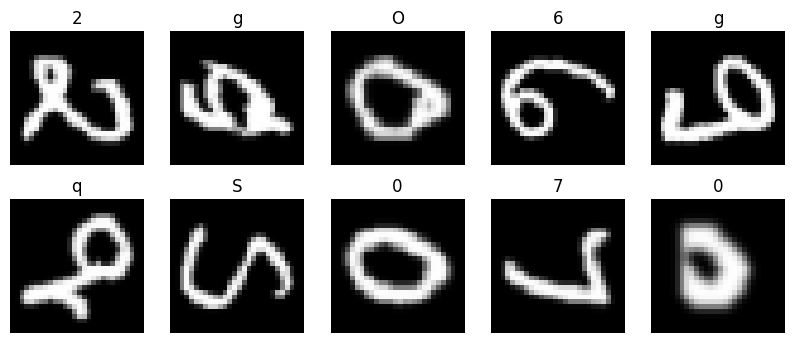

KeyboardInterrupt: 

In [3]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, random_split

# Transform: Normalize to [0,1], grayscale already
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.flip(x, dims=[2])),          # espelha horizontalmente
    transforms.Normalize((0.5,), (0.5,))
])

# Load EMNIST ByClass (62 classes: 0-9, A-Z, a-z)
train_data = datasets.EMNIST(root='./data', split='byclass', train=True, download=True, transform=transform)
test_data = datasets.EMNIST(root='./data', split='byclass', train=False, download=True, transform=transform)

print(f"Train samples: {len(train_data)}, Test: {len(test_data)}")
print(f"Classes: {train_data.classes}")  # 62 classes

# Split train into train/val (70/15/15 overall: ~70% train, ~15% val from train set)
train_size = int(0.82 * len(train_data))  # ~70% overall
val_size = len(train_data) - train_size
train_data, val_data = random_split(train_data, [train_size, val_size])

# Loaders (batch 64, adjust as needed)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# EDA: Visualize samples
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for i in range(10):
    img, label = train_data[i]
    axs[i//5, i%5].imshow(img.squeeze(), cmap='gray')
    axs[i//5, i%5].set_title(train_data.dataset.classes[label])
    axs[i//5, i%5].axis('off')
plt.show()

# Class distribution (imbalanced, so watch for it)
labels = [label for _, label in train_data]
unique, counts = np.unique(labels, return_counts=True)
plt.bar(unique, counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.transforms import RandomRotation, RandomAffine
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns

def rotate_tensor(x):
    return torch.rot90(x, 1, [1,2])

def flip_tensor(x):
    return torch.flip(x, [2])

transform = transforms.Compose([
    transforms.ToTensor(),
    rotate_tensor,
    flip_tensor,
    transforms.Normalize((0.5,), (0.5,))
])


# Load EMNIST ByClass (62 classes: 0-9, A-Z, a-z)
train_data = datasets.EMNIST(root='./data', split='byclass', train=True, download=True, transform=transform)
test_data = datasets.EMNIST(root='./data', split='byclass', train=False, download=True, transform=transform)

print(f"Train samples: {len(train_data)}, Test: {len(test_data)}")
print(f"Classes: {train_data.classes}")  # 62 classes

# Split train into train/val (70/15/15 overall: ~70% train, ~15% val from train set)
train_size = int(0.82 * len(train_data))  # ~70% overall
val_size = len(train_data) - train_size
train_data, val_data = random_split(train_data, [train_size, val_size])

# Loaders (batch 64, adjust as needed)
train_loader = DataLoader(train_data, batch_size=256, shuffle=True, num_workers=0)
val_loader = DataLoader(val_data, batch_size=256, shuffle=False, num_workers=0)

test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

from torchvision.transforms import RandomRotation, RandomAffine

aug_transform = transforms.Compose([
    RandomRotation(10),
    RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=62):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
train_data.dataset.transform = aug_transform
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)  # inicializa o modelo
criterion = nn.CrossEntropyLoss()  # função de perda
optimizer = optim.Adam(model.parameters(), lr=0.001)  # otimizador
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)  # decresce lr a cada 3 epochs



Train samples: 697932, Test: 116323
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [8]:
from tqdm import tqdm
import time

epochs = 10
best_acc = 0

for epoch in range(epochs):
    start = time.time()
    model.train()
    train_loss = 0
    total_batches = len(train_loader)

    # barra de progresso com tqdm
    loop = tqdm(enumerate(train_loader), total=total_batches, desc=f"Epoch {epoch+1}/{epochs}")

    for i, (imgs, labels) in loop:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        loop.set_postfix(loss=train_loss/(i+1))

    # Validação
    model.eval()
    correct = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            preds = model(imgs).argmax(dim=1)
            correct += (preds == labels).sum().item()

    val_acc = correct / len(val_data)
    elapsed_min = (time.time() - start) / 60

    print(
        f"Epoch {epoch+1} | "
        f"Loss: {train_loss/total_batches:.4f} | "
        f"Val Acc: {val_acc:.2f}% | "
        f"Time: {elapsed_min:.2f} min"
    )

    # Salva o modelo apenas se a acurácia melhorar
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "emnist_model.pt")
        print(f"Nova melhor acurácia: {best_acc:.2f}%. Modelo salvo.")


Epoch 1/10:  17%|█▋        | 391/2236 [00:39<03:07,  9.86it/s, loss=0.479]


KeyboardInterrupt: 

c:\Users\4534\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Acc: 0.1078 | Prec: 0.1327 | Rec: 0.1078 | F1: 0.0907


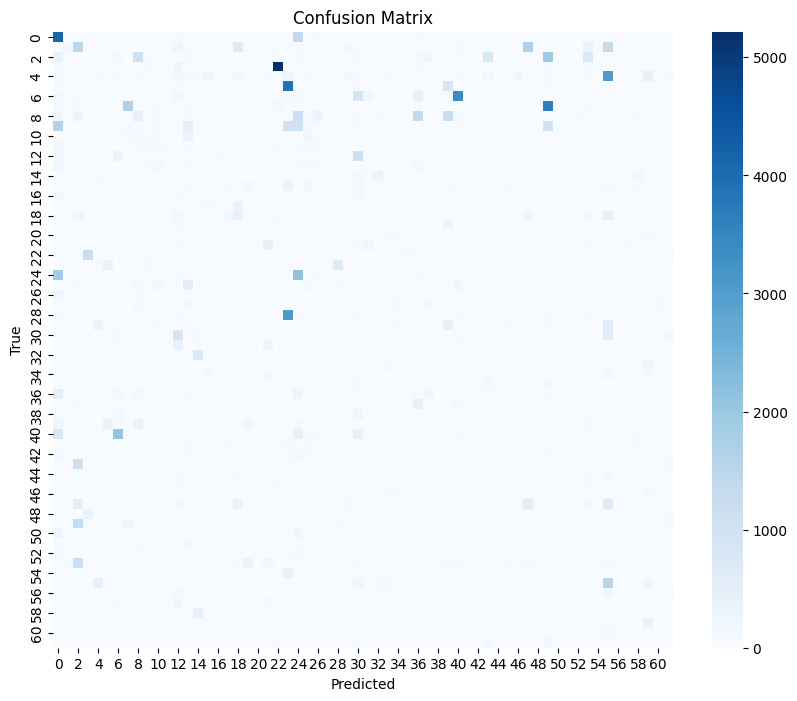

In [13]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.numpy())

acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average="weighted"
)

print(f"Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f}")
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()